In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [6]:
import numpy as np 
from numpy.linalg import cholesky 
import matplotlib.pyplot as plt 
from tqdm import tqdm_notebook as tqdm

In [9]:
import models.l63f as mdl_l63
from methods.generate_data import generate_data
from methods.LLR_forecasting_CV import m_LLR
from methods.model_forecasting import m_true
from methods.k_choice import k_choice
from methods.CPF_BS_smoothing import _CPF_BS
from methods.SEM import CPF_BS_SEM
from methods.npSEM import LLR_CPF_BS_SEM
from methods.regression_2 import regression_2
from methods.EnKS import _EnKS
from save_load import saveTr, loadTr
from methods.additives import RMSE

## GENERATE SIMULATED DATA (LORENZ-63 MODEL)

- parameters

In [10]:
dx = 3 # dimension of the state
dt_int = 0.01 # fixed integration time
dt_model = 8 # chosen number of model time step  \in [1, 25]-the larger dt_model the more nonliner model
var_obs = np.array([0,1,2]) # indices of the observed variables
dy = len(var_obs) # dimension of the observations
H = np.eye(dx)
#H = H[(0,2),:] #  first and third variables are observed
h = lambda x: H.dot(x)  # observation model
jacH = lambda x: H # Jacobian matrix  of the observation model(for EKS_EM only)
sigma = 10.0
rho = 28.0
beta = 8.0/3 # physical parameters
fmdl=mdl_l63.M(sigma=sigma, rho=rho, beta=beta, dtcy= dt_int)
mx = lambda x: fmdl.integ(x) # fortran version (fast)
jac_mx = lambda x: l63_jac(x, dt_int*dt_model, sigma, rho, beta) # python version (slow)

# Setting covariances
sig2_Q = 1; sig2_R = 2 # parameters
Q_true = np.eye(dx) *sig2_Q # model covariance
R_true = np.eye(dx) *sig2_R # observation covariance

# prior state
x0 = np.r_[8, 0, 30]

# generate data
T_burnin = 5*10**3
T_train = 10*10**2 # length of the catalog
T_test = 10*10**2 # length of the testing data
X_train, Y_train, X_test, Y_test, yo = generate_data(x0,mx,h,Q_true,R_true,dt_int,dt_model,var_obs, T_burnin, T_train, T_test) 
X_train.time = np.arange(0,T_train)
Y_train.time= X_train.time[1:]
#np.random.seed(0);# random number generator
N=np.size(Y_train.values);Ngap= np.floor(N/10); # create gaps: 10 percent of missing values
indX=np.random.choice(np.arange(0,N), int(Ngap), replace=False);
ind_gap_taken = divmod(indX ,len(Y_train.time));
Y_train.values[ind_gap_taken]=np.nan;

X_train0, Y_train0, X_test0, Y_test0, yo0 = generate_data(X_train.values[:,-1],mx,h,Q_true,R_true,dt_int,dt_model,var_obs, T_burnin, T_train, T_test) 
X_train0.time = np.arange(0,T_train)
Y_train0.time= X_train0.time[1:]

# PLOT STATE, OBSERVATIONS AND CATALOG

## state and observations (when available)

Text(0.5,1,'Lorenz-63 true (continuous lines) and observed trajectories (points)')

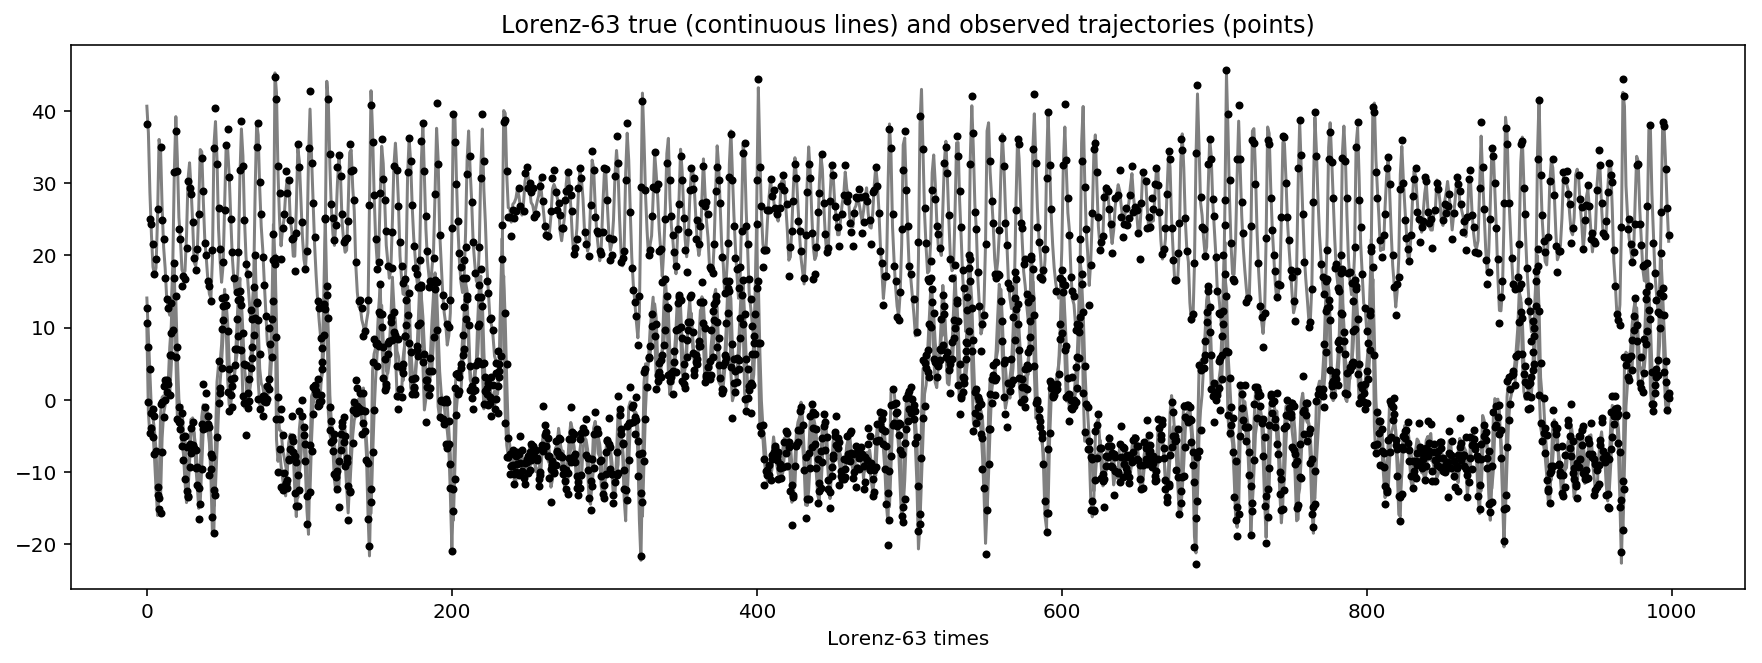

In [11]:
plt.rcParams['figure.figsize'] = (15, 5)
plt.figure(1)
plt.plot(X_train.values[:,1:].T,'-', color='grey')
plt.plot(Y_train.values.T,'.k', markersize= 6)
plt.xlabel('Lorenz-63 times')
plt.title('Lorenz-63 true (continuous lines) and observed trajectories (points)')

In [12]:
class estQ:
    value = Q_true
    type = 'adaptive' # chosen predefined type of model error covatiance ('fixed', 'adaptive')
    form = 'constant' # chosen esimated matrix form ('full', 'diag', 'constant')
    base =  np.eye(dx) # for fixed base of model covariance (for 'constant' matrix form only)
    decision = True # chosen if Q is estimated or not ('True', 'False')

class estR:
    value = R_true
    type = 'adaptive' # chosen predefined type of observation error covatiance ('fixed', 'adaptive')
    form = 'constant' # chosen esimated matrix form ('full', 'diag', 'constant')
    base =  np.eye(dx) # for fixed base of model covariance
    decision = True # chosen if R is estimated or not ('True', 'False')
    
class estX0:
    decision = False # chosen if X0 is estimated or not ('True', 'False')
    
class estD: # for non-parametric approach only
    decision = True # chosen if the smoothed data is updated or not ('True', 'False')

    

    
## true_FORECASTING (dynamical model)

In [13]:
m = lambda x,pos_x,ind_x,Q: m_true(x,pos_x,ind_x, Q, mx,jac_mx, dt_model)
num_ana = 300
data_init = np.r_['0,2,0',Y_train.values[...,:-1], Y_train.values[...,1:]]
ind_nogap = np.where(~np.isnan(np.sum(data_init,0)))[0]

# LLR_FORECASTING

(non-parametric dynamical model constructed given the catalog)

parameters of the analog forecasting method

In [14]:
class LLR:
    
    class data:
        ana = np.zeros((dx,1,len(ind_nogap)))
        suc = np.zeros((dx,1,len(ind_nogap)))
        ana[:,0,:] =data_init[:dx,ind_nogap]
        suc[:,0,:]  = data_init[dx:,ind_nogap]
        time = Y_train.time[ind_nogap] # catalog with analogs and successors
    
    class data_prev:
        ana =data_init[:dx,ind_nogap]
        suc = data_init[dx:,ind_nogap]
        time = Y_train.time[ind_nogap] # catalog with analogs and successors
    
    
    lag_x = 5 # lag of removed analogs around x to avoid an over-fitting forecast
    lag_Dx = lambda Dx: np.shape(Dx)[-1] #15 lag of moving window of analogs chosen around x 
    time_period = 1 # set 365.25 for year and 
    k_m = [] # number of analogs 
    k_Q = [] # number of analogs 
    nN_m = np.arange(20,num_ana,50) #number of analogs to be chosen for mean estimation
    nN_Q = np.arange(20,num_ana,50) #number of analogs to be chosen for dynamical error covariance
    lag_k = 1 #chosen the lag for k reestimation 
    estK = 'same' # set 'same' if k_m = k_Q chosen, otherwise, set 'different'
    kernel = 'tricube'# set 'rectangular' or 'tricube'
    k_lag = 20
    k_inc= 10
    Q = estQ
    gam = 1
    

/Users/navaro/PycharmProjects/lorenz63/methods/LLR_forecasting_CV.py:102: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  M = np.linalg.lstsq(Aw.T,Bw.T)[0];


<Figure size 576x360 with 0 Axes>

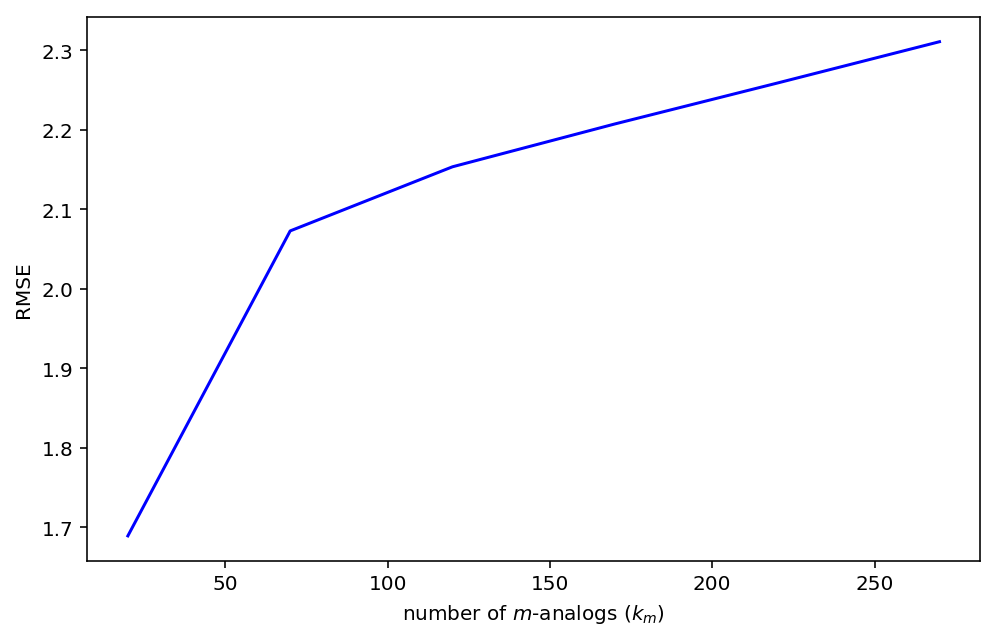

In [16]:
    
time = np.arange(T_train)

# run the analog data assimilation
k_m, k_Q = k_choice(LLR,LLR.data.ana,LLR.data.suc,LLR.data.time)    
LLR.k_m =k_m; LLR.k_Q =k_Q; #LLR.lag_x = 0



In [ ]:
LLR.lag_x=0
xf, mean_xff, Q_xf, M_xf = m_LLR(X_test.values[:,:-1],
                                 1,np.ones([1]),LLR)
time = np.arange(0,T_test-1)
B = Q_true
xb= X_test.values[...,0]
N_iter = 100
Nf = 10# number of particles
Ns =5 # number of realizations

X_conditioning = np.zeros([dx,T_test])
err_smo = 0
err_fil = 0
m_hat = lambda  x,pos_x,ind_x: m_LLR(x,pos_x,ind_x,LLR)   

for j in tqdm(range(N_iter)):
    
    if j==0:
        Xss,_,_= _EnKS(dx, 20, len(X_test.time[1:]), 
                       H, 
                       R_true, Y_test.values,
                       X_test.values, dy, xb, 
                       B, LLR.Q.value, 1, m_hat)
        X_conditioning = np.mean(Xss,1)
        
    Xs,Xa,Xf,_,_,loglik = _CPF_BS(Y_test.values,
                                  X_test.values,
                                  m_hat, 
                                  Q_true, 
                                  H, 
                                  R_true,
                                  xb,
                                  B, 
                                  X_conditioning,
                                  dx, 
                                  Nf, 
                                  Ns,
                                  time)
    X_conditioning = Xs[:,-1,:]
    
    if j >5:
        err_smo +=  ((Xs.mean(1)-X_test.values)**2)
        err_fil +=  ((Xa.mean(1)-X_test.values)**2)
        
print('smo={}, fil={}'.format(np.sqrt(np.mean(err_smo)/N_iter), 
                              np.sqrt(np.mean(err_fil)/N_iter)))

print(RMSE(mean_xff-X_test.values[:,1:]))

/Users/navaro/PycharmProjects/lorenz63/methods/LLR_forecasting_CV.py:102: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  M = np.linalg.lstsq(Aw.T,Bw.T)[0];


# (SEM): STOCHASTIC EXPECATION-MAXIMIZATION  vs (npSEM): NON-PARAMETRIC STOCHASTIC EXPECATION-MAXIMIZATION 

# SETTING PARAMETERS 

In [ ]:
N_iter =100 # number of iterations of EM algorithms
# Step functions
gam1 = np.ones(N_iter,dtype=int)  #for SEM (stochastic EM)
gam2 = np.ones(N_iter, dtype=int)
for k in range(50,N_iter):
    gam2[k] = k**(-0.7) # for SAEM (stochastic approximation EM)

rep = 1 # number of repetitions for each algorithm
X_conditioning = np.zeros([dx,T_train+1]) # the conditioning trajectory (only for CPF-BS-SEM and CPF-AS-SEM)
B = Q_true
xb= X_train.values[...,0]
# initial parameters
aintQ = 0.5
bintQ = 5
aintR = 1
bintR = 5
    
Nf = 10# number of particles
Ns = 5 # number of realizations

In [ ]:
R_init = .5*np.eye(dy)    
Q_init = 3*np.eye(dx)
LLR.Q.value = Q_init
estD.decision = True
LLR.lag_x =5
LLR.Q = estQ
LLR.data.ana = np.zeros((dx,1,len(ind_nogap)))
LLR.data.suc = np.zeros((dx,1,len(ind_nogap)))
LLR.data.ana[:,0,:] =data_init[:dx,ind_nogap]
LLR.data.suc[:,0,:] = data_init[dx:,ind_nogap]
LLR.data.time = Y_train.time[ind_nogap] 

LLR.Q.value = Q_init
k_m, k_Q = k_choice(LLR,LLR.data.ana,LLR.data.suc,LLR.data.time)    
LLR.k_m =k_m
LLR.k_Q =k_Q

m_hat = lambda  x,pos_x,ind_x: m_LLR(x,pos_x,ind_x,LLR)
Xs, _, _ = _EnKS(dx, 20, len(time[1:]), H, R_init, 
                 Y_train.values,X_train.values, 
                 dy, xb, B, Q_init, 1, m_hat)

X_conditioning = np.squeeze(Xs.mean(1))

out_npSEM_adap = LLR_CPF_BS_SEM(Y_train.values,
                                X_train.values, 
                                LLR, H, 
                                R_init,xb,B, 
                                X_conditioning,dx, 
                                Nf, Ns,X_train.time, 
                                N_iter, gam1, 
                                estD, estQ, 
                                estR, estX0)
